## Supply Chain Optimisation

### Predicting delivery risk
what is the probability that the shipment would arrive late?

### Dataset

The PEPFAR Supply Chain Management System (SCMS) Delivery History dataset contains detailed, shipment-level records for antiretroviral (ARV) and HIV laboratory testing kits delivered to various countries. This data is primarily used for analyzing logistics performance, such as on-time delivery percentages, delivery delays, and costs.

In [1]:
import os
os.chdir("/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file_path = "data/supply_chain.csv"
try:
  df = pd.read_csv(file_path,encoding='latin1')
except Exception as e:
  print(e)

### Data Analysis

In [3]:
#create a copy of the original dataframe for EDA
eda_df = df.copy()
eda_df.shape

(10324, 33)

In [4]:
eda_df.head(5)

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [5]:
# check the info of the dataframe
eda_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  str    
 2   PQ #                          10324 non-null  str    
 3   PO / SO #                     10324 non-null  str    
 4   ASN/DN #                      10324 non-null  str    
 5   Country                       10324 non-null  str    
 6   Managed By                    10324 non-null  str    
 7   Fulfill Via                   10324 non-null  str    
 8   Vendor INCO Term              10324 non-null  str    
 9   Shipment Mode                 9964 non-null   str    
 10  PQ First Sent to Client Date  10324 non-null  str    
 11  PO Sent to Vendor Date        10324 non-null  str    
 12  Scheduled Delivery Date       10324 non-null  str    
 13  Delivered to

In [6]:
# identify the categorical, numerical and date columns
cat_cols = eda_df.select_dtypes(include=['str','object']).columns.to_list()
num_cols = eda_df.select_dtypes(include=['int64','float64']).columns.to_list()
date_cols = [curr_col for curr_col in cat_cols if 'date' in curr_col.lower()]

#convert str to datetime
for col in date_cols:
    eda_df[col] = pd.to_datetime(eda_df[col], errors='coerce')

print(num_cols)
print(cat_cols)
print(date_cols)

['ID', 'Unit of Measure (Per Pack)', 'Line Item Quantity', 'Line Item Value', 'Pack Price', 'Unit Price', 'Line Item Insurance (USD)']
['Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country', 'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode', 'PQ First Sent to Client Date', 'PO Sent to Vendor Date', 'Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date', 'Product Group', 'Sub Classification', 'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage', 'Dosage Form', 'Manufacturing Site', 'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)']
['PQ First Sent to Client Date', 'PO Sent to Vendor Date', 'Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date']


/var/folders/gz/zjfnlbpd6393dctbf4vzjdc00000gn/T/ipykernel_60560/848423506.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  eda_df[col] = pd.to_datetime(eda_df[col], errors='coerce')
/var/folders/gz/zjfnlbpd6393dctbf4vzjdc00000gn/T/ipykernel_60560/848423506.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  eda_df[col] = pd.to_datetime(eda_df[col], errors='coerce')
/var/folders/gz/zjfnlbpd6393dctbf4vzjdc00000gn/T/ipykernel_60560/848423506.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  eda_df[col] = pd.to_datetime(eda_df[col], errors='coerce')
/var/folders/gz/zjfnlb

In [7]:
#null values in the dataframe
eda_df.isnull().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                    360
PQ First Sent to Client Date    2681
PO Sent to Vendor Date          5732
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

In [8]:
#duplicate values in the dataframe
eda_df.duplicated().sum()

np.int64(0)

late
0    0.885122
1    0.114878
Name: proportion, dtype: float64

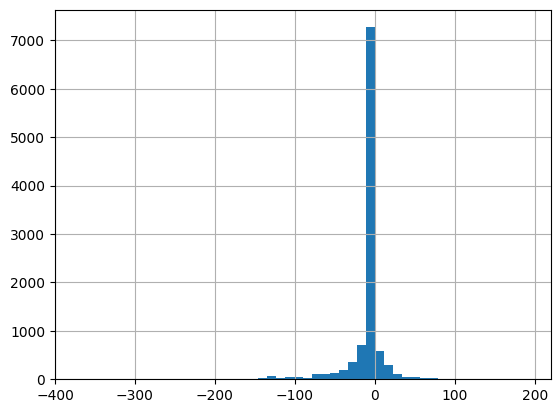

In [9]:
#Create delay features for EDA only
eda_df['delay_days'] = (eda_df['Delivered to Client Date'] - eda_df['Scheduled Delivery Date']).dt.days
eda_df['lead_time'] = (eda_df['Scheduled Delivery Date'] - eda_df['PO Sent to Vendor Date']).dt.days
eda_df['processing_time'] = (eda_df['PO Sent to Vendor Date'] - eda_df['PQ First Sent to Client Date']).dt.days
eda_df['scheduled_month'] = eda_df['Scheduled Delivery Date'].dt.month
eda_df['scheduled_quarter'] = eda_df['Scheduled Delivery Date'].dt.quarter
eda_df['scheduled_weekday'] = eda_df['Scheduled Delivery Date'].dt.weekday

eda_df['late'] = (eda_df['delay_days'] > 0).astype(int)

eda_df['delay_days'].hist(bins=50)
eda_df['late'].value_counts(normalize=True)

Late rate by Shipment Mode:


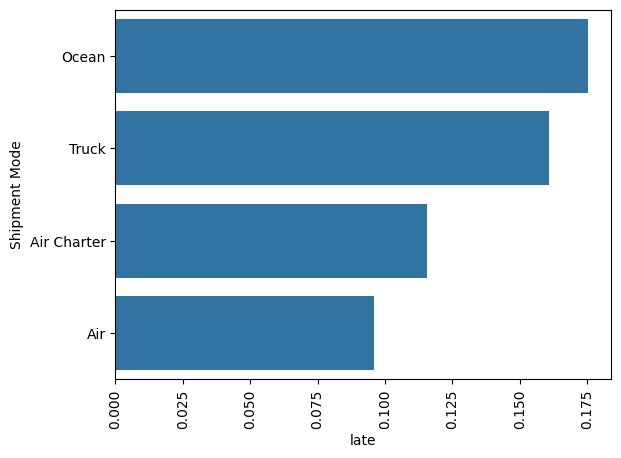

Late rate by Country:


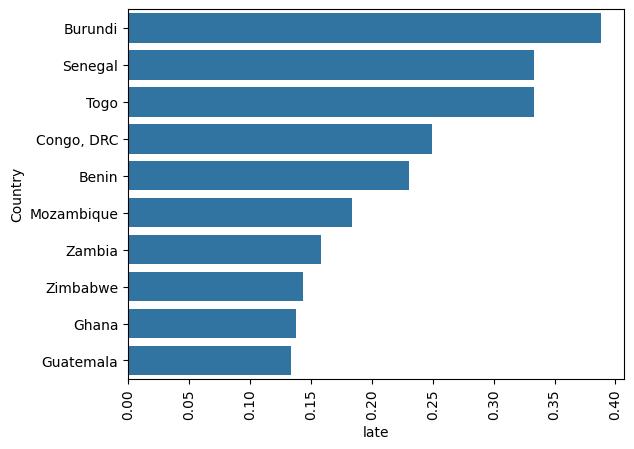

Late rate by Vendor:


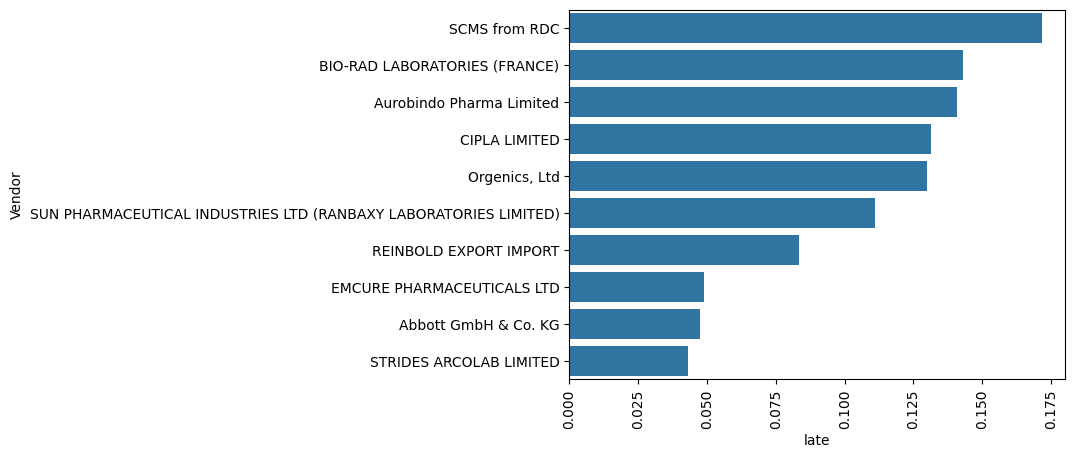

Late rate by Manufacturing Site:


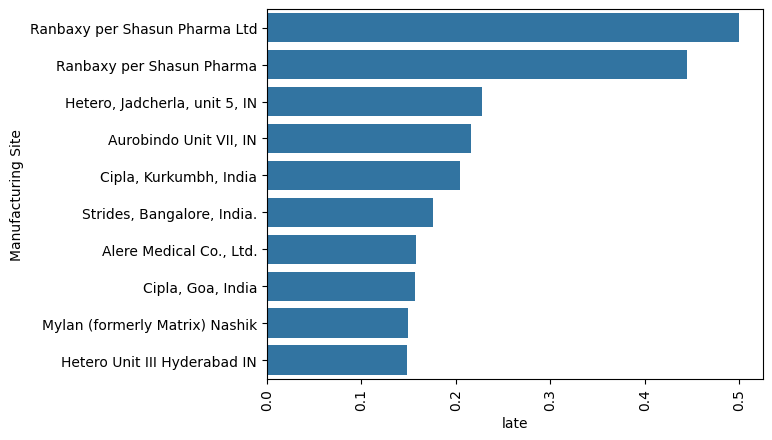

In [10]:
#check late rate by differnet categorical features - top 10 most late features
lateness_catogorical_cols = ['Shipment Mode', 'Country', 'Vendor','Manufacturing Site']
for col in lateness_catogorical_cols:
    print(f"Late rate by {col}:")
    sns.barplot(x='late', y=col, data=eda_df.groupby(col)['late'].mean().reset_index().sort_values('late', ascending=False)[:10])
    plt.xticks(rotation=90)
    plt.show()

In [11]:
#numeric summary
eda_df[num_cols].describe()


,ID,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Line Item Insurance (USD)
count,10324.000000,10324.000000,10324.000000,1.032400e+04,10324.000000,10324.000000,10037.000000
mean,51098.968229,77.990895,18332.534870,1.576506e+05,21.910241,0.611701,240.117626
std,31944.332496,76.579764,40035.302961,3.452921e+05,45.609223,3.275808,500.190568
min,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,12795.750000,30.000000,408.000000,4.314593e+03,4.120000,0.080000,6.510000
50%,57540.500000,60.000000,3000.000000,3.047147e+04,9.300000,0.160000,47.040000
75%,83648.250000,90.000000,17039.750000,1.664471e+05,23.592500,0.470000,252.400000
max,86823.000000,1000.000000,619999.000000,5.951990e+06,1345.640000,238.650000,7708.440000


array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'Unit of Measure (Per Pack)'}>,
        <Axes: title={'center': 'Line Item Quantity'}>],
       [<Axes: title={'center': 'Line Item Value'}>,
        <Axes: title={'center': 'Pack Price'}>,
        <Axes: title={'center': 'Unit Price'}>],
       [<Axes: title={'center': 'Line Item Insurance (USD)'}>, <Axes: >,
        <Axes: >]], dtype=object)

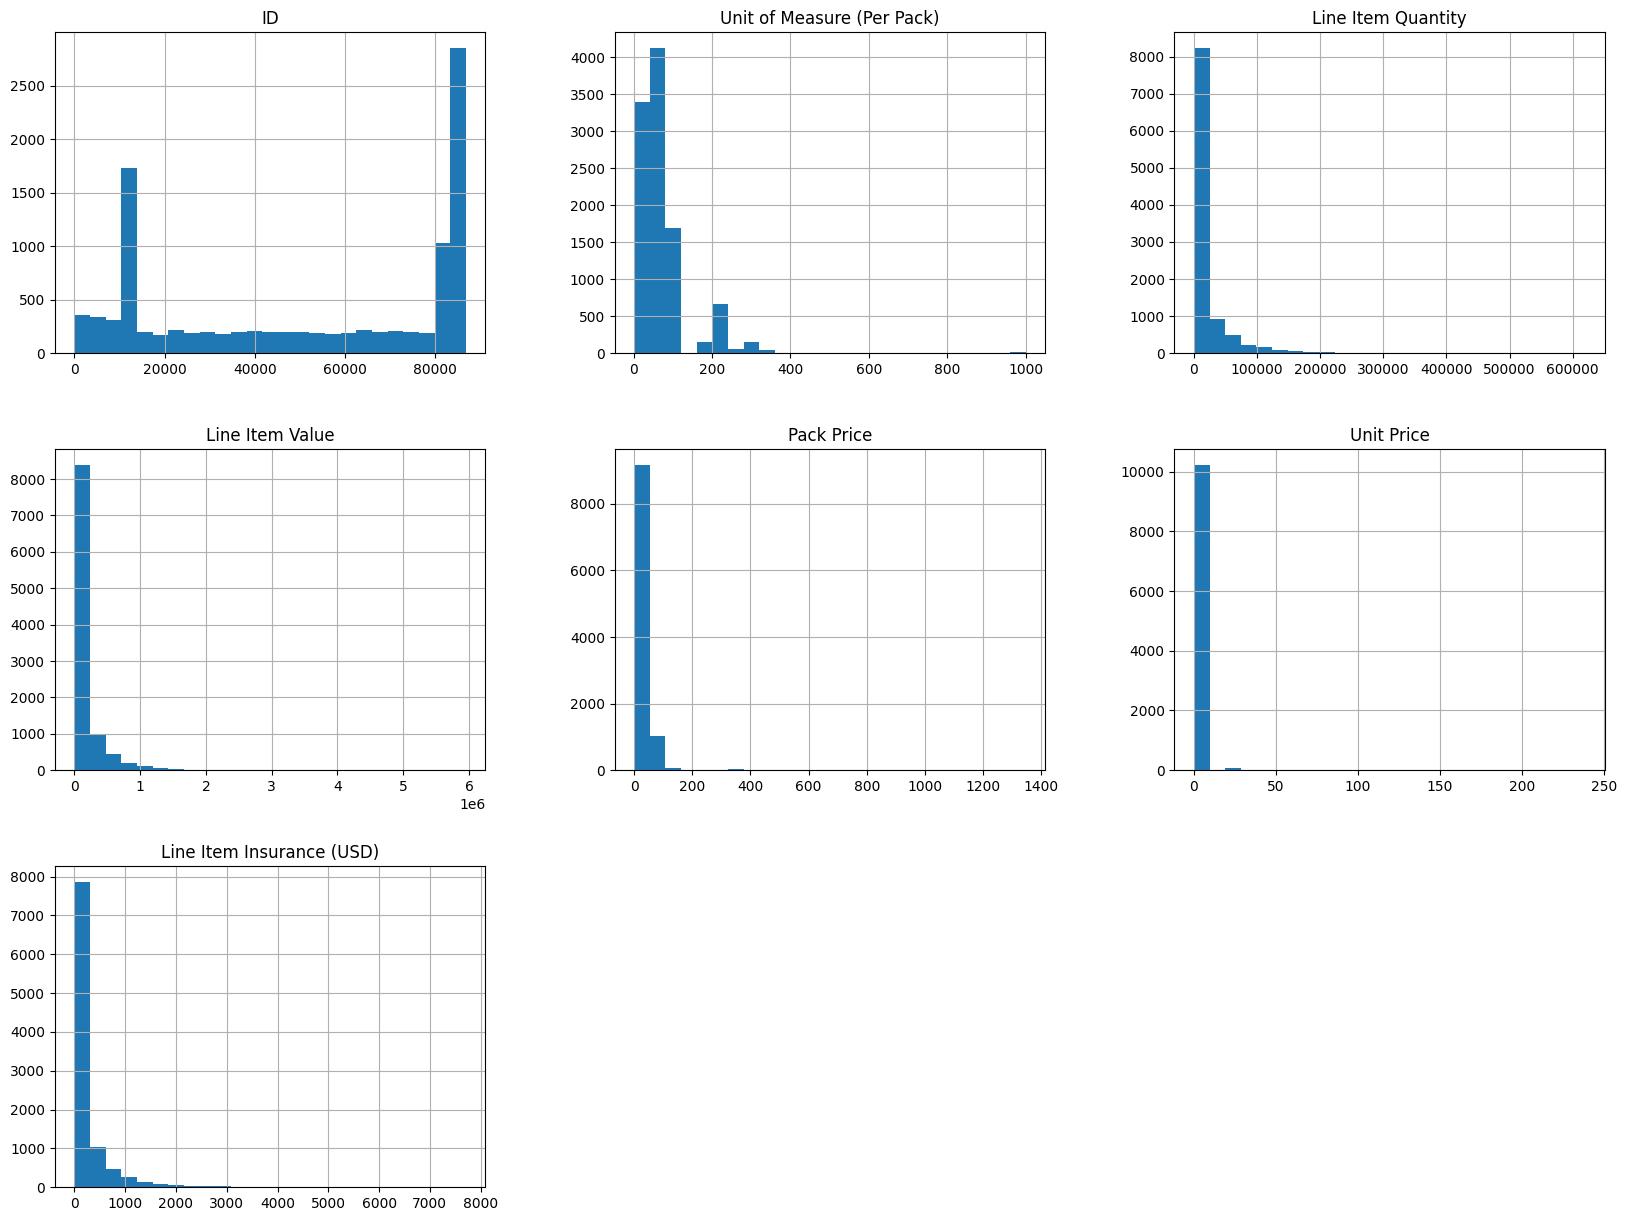

In [12]:
#distribution of numeric features
eda_df[num_cols].hist(bins=25, figsize=(20,15))

<Axes: >

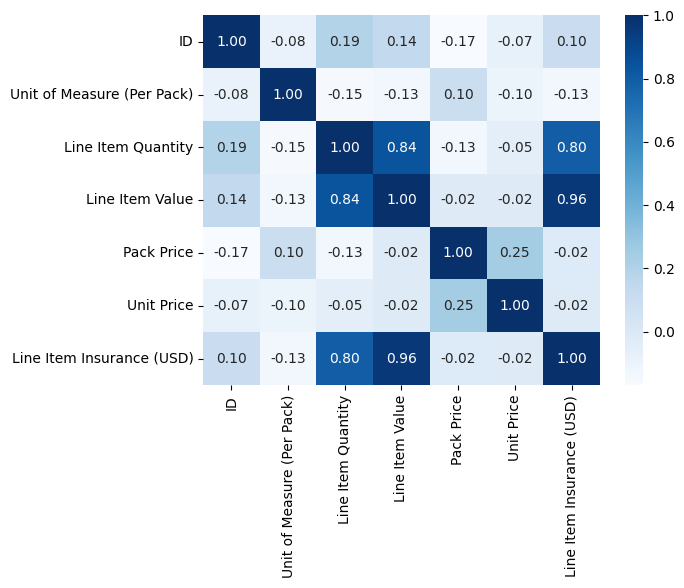

In [13]:
#heatmap of correlation between numeric features
sns.heatmap(eda_df[num_cols].corr(),cmap='Blues', annot=True, fmt=".2f")

In [14]:
# null values in the dataframe
eda_df.isnull().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                    360
PQ First Sent to Client Date    2681
PO Sent to Vendor Date          5732
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

Shipments with missing processing time exhibited more than double the delay probability (14.7% vs 6.1%), suggesting that incomplete workflow documentation is associated with operational risk.

In [15]:
#does missing values in the date columns have higher late rate?
eda_df["processing_time_missing"] = eda_df["processing_time"].isna().astype(int)
missing_delay_rate = eda_df.groupby("processing_time_missing")["late"].mean()
print(missing_delay_rate)

processing_time_missing
0    0.060645
1    0.147023
Name: late, dtype: float64


In [16]:

from scipy.stats import chi2_contingency

contingency = pd.crosstab(eda_df["processing_time_missing"], eda_df["late"])
chi2, p, _, _ = chi2_contingency(contingency)

print("p-value:", p)
print("Is p < 0.05?", p < 0.05)

p-value: 3.354199487186643e-40
Is p < 0.05? True


In [17]:
#check the dimensioality of the column data
for col in cat_cols:
    print(f"{col} has {eda_df[col].nunique()} unique values")

Project Code has 142 unique values
PQ # has 1237 unique values
PO / SO # has 6233 unique values
ASN/DN # has 7030 unique values
Country has 43 unique values
Managed By has 4 unique values
Fulfill Via has 2 unique values
Vendor INCO Term has 8 unique values
Shipment Mode has 4 unique values
PQ First Sent to Client Date has 763 unique values
PO Sent to Vendor Date has 895 unique values
Scheduled Delivery Date has 2006 unique values
Delivered to Client Date has 2093 unique values
Delivery Recorded Date has 2042 unique values
Product Group has 5 unique values
Sub Classification has 6 unique values
Vendor has 73 unique values
Item Description has 184 unique values
Molecule/Test Type has 86 unique values
Brand has 48 unique values
Dosage has 54 unique values
Dosage Form has 17 unique values
Manufacturing Site has 88 unique values
First Line Designation has 2 unique values
Weight (Kilograms) has 4688 unique values
Freight Cost (USD) has 6733 unique values


In [18]:
#value counts for categorical columns
for col in cat_cols:
    print(f"Value counts for {col}:")
    print(eda_df[col].value_counts(normalize=True).head(10))
    print("\n")

Value counts for Project Code:
Project Code
116-ZA-T30    0.074390
104-CI-T30    0.070612
151-NG-T30    0.060829
114-UG-T30    0.057730
108-VN-T30    0.050562
106-HT-T30    0.043588
111-MZ-T30    0.041747
110-ZM-T30    0.039326
109-TZ-T30    0.035742
107-RW-T30    0.032933
Name: proportion, dtype: float64


Value counts for PQ #:
PQ #
Pre-PQ Process    0.259686
FPQ-14942         0.019857
FPQ-12522         0.014917
FPQ-13973         0.010655
FPQ-4537          0.009492
FPQ-8840          0.008718
FPQ-7175          0.007555
FPQ-5303          0.007555
FPQ-6262          0.007265
FPQ-5023          0.006780
Name: proportion, dtype: float64


Value counts for PO / SO #:
PO / SO #
SCMS-199289    0.006490
SCMS-199283    0.006102
SCMS-183950    0.005327
SCMS-259075    0.003681
SCMS-215370    0.003681
SCMS-259079    0.003196
SCMS-23500     0.002518
SCMS-215410    0.002518
SCMS-162440    0.001937
SCMS-259078    0.001937
Name: proportion, dtype: float64


Value counts for ASN/DN #:
ASN/DN #
ASN-19166

In [19]:
#check skewness of numeric features
numeric_cols = ["Weight (Kilograms)","Freight Cost (USD)"]  
for col in numeric_cols:
    eda_df[col] = (
        pd.to_numeric(eda_df[col], errors='coerce')
    )
    skewness = eda_df[col].skew()
    print(f"Skewness of {col}: {skewness}")

Skewness of Weight (Kilograms): 42.50590318409663
Skewness of Freight Cost (USD): 4.688022585166202


In [20]:
eda_df["Freight Cost (USD)"].unique()

array([  780.34,  4521.5 ,  1653.78, ...,  3785.72, 26180.  ,  3410.  ],
      shape=(5433,))

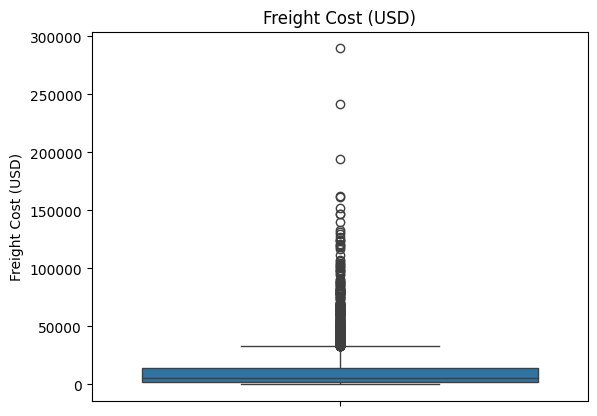

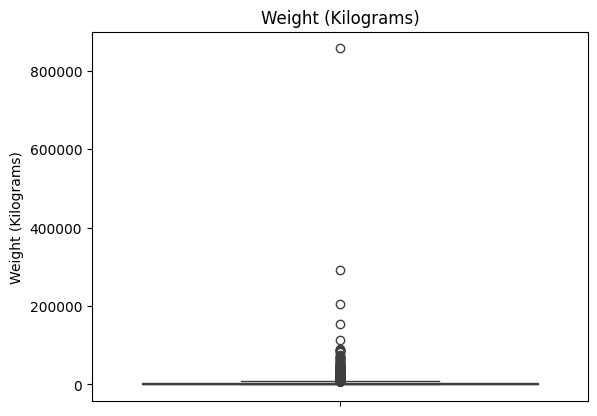

In [21]:
plt.figure()
sns.boxplot(y=eda_df["Freight Cost (USD)"])
plt.title("Freight Cost (USD)")
plt.show()

plt.figure()
sns.boxplot(y=eda_df["Weight (Kilograms)"])
plt.title("Weight (Kilograms)")
plt.show()


In [22]:
#log transformation for skewed features
eda_df["Freight Cost (USD)"] = np.log1p(eda_df["Freight Cost (USD)"])
eda_df["Weight (Kilograms)"] = np.log1p(eda_df["Weight (Kilograms)"])

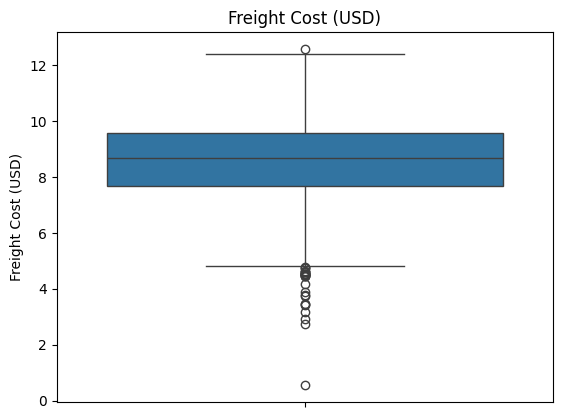

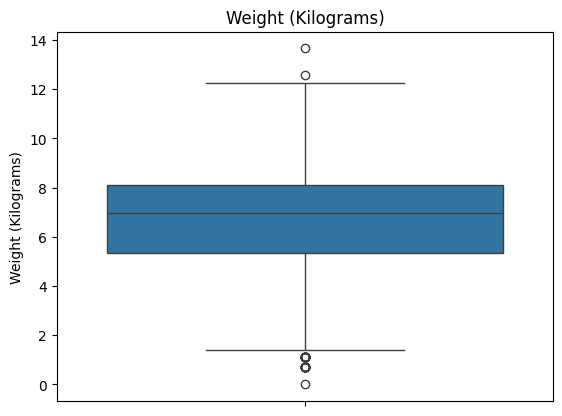

In [23]:
plt.figure()
sns.boxplot(y=eda_df["Freight Cost (USD)"])
plt.title("Freight Cost (USD)")
plt.show()

plt.figure()
sns.boxplot(y=eda_df["Weight (Kilograms)"])
plt.title("Weight (Kilograms)")
plt.show()


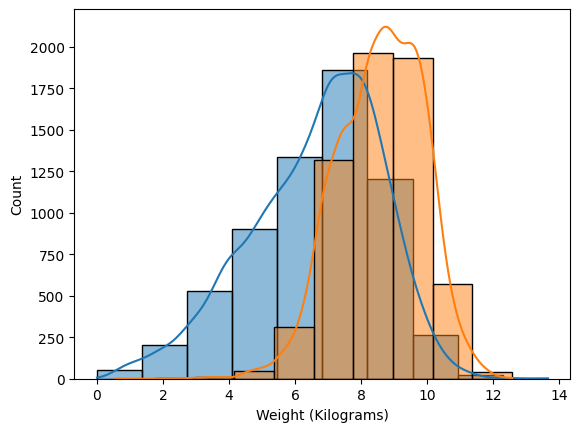

In [24]:
numeric_cols = ["Weight (Kilograms)","Freight Cost (USD)"] 
for col in numeric_cols:
    sns.histplot(eda_df[col], bins=10, kde=True)

<Axes: xlabel='count', ylabel='Vendor'>

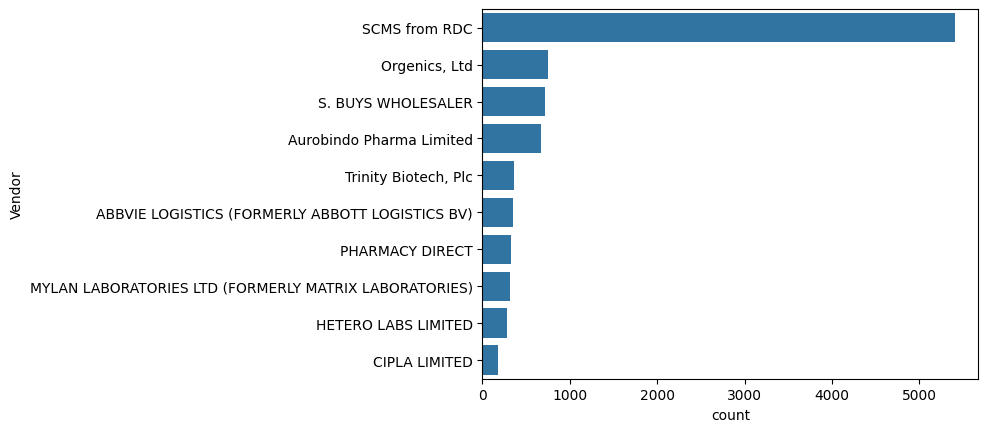

In [25]:
#most popular vendors
sns.countplot(y='Vendor', data=eda_df, order=eda_df['Vendor'].value_counts().index[:10])


<Axes: xlabel='scheduled_month', ylabel='delay_days'>

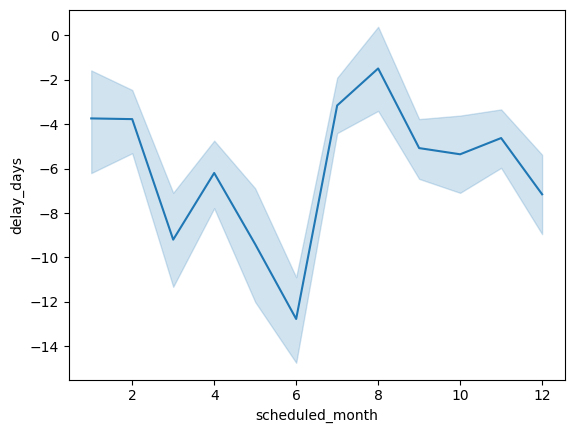

In [26]:
#delivery delay by month
sns.lineplot(x='scheduled_month', y='delay_days', data=eda_df)


In [27]:
#combined feartures
eda_df.groupby(['Shipment Mode','Country'])['late'].mean().sort_values(ascending=False)
eda_df.groupby(['Vendor','Shipment Mode'])['late'].mean().sort_values(ascending=False)


Vendor                          Shipment Mode
EMCURE PHARMACEUTICALS LTD      Ocean            0.400000
Aurobindo Pharma Limited        Ocean            0.269231
SCMS from RDC                   Truck            0.232461
CIPLA LIMITED                   Ocean            0.222222
REINBOLD EXPORT IMPORT          Truck            0.166667
                                                   ...   
HETERO LABS LIMITED             Ocean            0.000000
                                Air Charter      0.000000
GLAXOSMITHKLINE EXPORT LIMITED  Ocean            0.000000
                                Air              0.000000
ZEPHYR BIOMEDICALS              Air              0.000000
Name: late, Length: 95, dtype: float64

In [28]:
#convert the date features to pd.datetime and create the late feature for modeling
def process_dates(df:pd.DataFrame)->pd.DataFrame:
    cat_cols = df.select_dtypes(include=['str','object']).columns.to_list()
    date_cols = [curr_col for curr_col in cat_cols if 'date' in curr_col.lower()]

    #convert str to datetime
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    df['late'] = (df['Delivered to Client Date'] - df['Scheduled Delivery Date']).dt.days
    df['late'] = (df['late'] > 0).astype(int)

    return df

processed_df = process_dates(df)


/var/folders/gz/zjfnlbpd6393dctbf4vzjdc00000gn/T/ipykernel_60560/3788214607.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/gz/zjfnlbpd6393dctbf4vzjdc00000gn/T/ipykernel_60560/3788214607.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/gz/zjfnlbpd6393dctbf4vzjdc00000gn/T/ipykernel_60560/3788214607.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/var/folders/gz/zjfnlbpd6393dctbf4vzjdc0000

### Train Test Split

In [29]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["late"])
y = df["late"]

X_holdout, X_test, y_holdout, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=10)

X_train, X_val, y_train, y_val = train_test_split(
    X_holdout,
    y_holdout,
    test_size=0.3,
    random_state=10
)

print("length of dataset:",len(df))
print("length of train set:",len(X_train))
print("length of val set:",len(X_val))
print("length of test set:",len(X_test))

length of dataset: 10324
length of train set: 5781
length of val set: 2478
length of test set: 2065


### Sklearn pipeline

In [30]:
#functions for data cleaning and feature engineering

def clean_data(df:pd.DataFrame)->pd.DataFrame:

    # identify the categorical, numerical and date columns
    cat_cols = df.select_dtypes(include=['str','object']).columns.to_list()
    num_cols = df.select_dtypes(include=['int64','float64']).columns.to_list()
    date_cols = [curr_col for curr_col in cat_cols if 'date' in curr_col.lower()]

    #convert str to datetime
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    #drop duplicates
    df = df.drop_duplicates()

    #drop transaction id
    DROP_COLS = ["PQ #", "PO / SO #","ASN/DN #"]
    df = df.drop(columns=DROP_COLS)

    return df

def feature_engineer_dates(df:pd.DataFrame) -> pd.DataFrame:

    #create new features based on the date columns
    df['lead_time'] = (df['Scheduled Delivery Date'] - df['PO Sent to Vendor Date']).dt.days
    df['processing_time'] = (df['PO Sent to Vendor Date'] - df['PQ First Sent to Client Date']).dt.days
    df['scheduled_month'] = df['Scheduled Delivery Date'].dt.month
    df['scheduled_quarter'] = df['Scheduled Delivery Date'].dt.quarter
    df['scheduled_weekday'] = df['Scheduled Delivery Date'].dt.weekday

    #drop the original date columns after feature engineering
    date_cols = [curr_col for curr_col in cat_cols if 'date' in curr_col.lower()]
    df = df.drop(columns=date_cols)

    return df


In [31]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer, FunctionTransformer, Pipeline
from sklearn.preprocessing import TargetEncoder
from sklearn.impute import SimpleImputer

numeric_cols = ["Weight (Kilograms)","Freight Cost (USD)"]  
one_hot_cols = ["Managed By","Fulfill Via","Vendor INCO Term","Shipment Mode","Product Group","Sub Classification","Dosage Form","First Line Designation"]
target_encode_cols = ["Country","Brand","Dosage","Project Code","Vendor", "Item Description","Molecule/Test Type","Manufacturing Site"]

numeric_pipeline = Pipeline(steps=[
    ("to_numeric", FunctionTransformer(lambda X: X.apply(pd.to_numeric, errors='coerce'), validate=False)), #convert to numeric and coerce errors to NaN for imputation
    ("imputer", SimpleImputer(strategy="mean")), #fill nan values with mean
    ("log", FunctionTransformer(np.log1p, validate=False)), #log transformation for skewed features
    ("scaler", StandardScaler()) #scale for logisitic regression
])

categorical_pipeline = ColumnTransformer(
transformers=[
    ("target", TargetEncoder(smooth="auto"), target_encode_cols), #high cardinality features
    ("onehot", OneHotEncoder(handle_unknown="ignore"), one_hot_cols) #low cardinality features
]
)

preprocessor = ColumnTransformer(
transformers=[
    ("num", numeric_pipeline, numeric_cols), 
    ("cat", categorical_pipeline, one_hot_cols + target_encode_cols),
]
)


### Baseline Model

In [32]:
#having all features, create a baseline model with logistic regression and evaluate the performance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss

full_pipeline = Pipeline(steps=[
    ("clean", FunctionTransformer(clean_data)),           
    ("feature_engineer", FunctionTransformer(feature_engineer_dates)), 
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))                          
])

full_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('clean', ...), ('feature_engineer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function cle...t 0x11755bd80>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments

In [33]:
#accuracy
y_pred = full_pipeline.predict(X_val)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, full_pipeline.predict_proba(X_val)[:, 1]))


              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2184
           1       0.53      0.03      0.06       294

    accuracy                           0.88      2478
   macro avg       0.71      0.51      0.50      2478
weighted avg       0.84      0.88      0.83      2478

ROC AUC Score: 0.8102067292118312


### Hyperparamter tuning using RandomSearch

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distributions = {
    "classifier__C": uniform(0.01, 10),
    "classifier__penalty": ["l1", "l2", "elasticnet"],
    "classifier__solver": ["saga"],          # saga supports l1/l2/elasticnet
    "classifier__l1_ratio": uniform(0, 1),   # only used if penalty="elasticnet"
    "classifier__class_weight": [None, "balanced"]
}

random_search = RandomizedSearchCV(
    estimator = full_pipeline,
    param_distributions = param_distributions,
    n_iter = 20,
    cv = 5,
    scoring = "roc_auc",
    random_state = 42,
)

random_search.fit(X_train, y_train)

print("Best C:", random_search.best_params_["classifier__C"])
print("Best ROC-AUC:", random_search.best_score_)


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1152: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.1834347898661638. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/Pa

Best C: 9.666320330745593
Best ROC-AUC: 0.8228458699744072


### Test Set Results and Error Checking

In [35]:
best_model = random_search.best_estimator_
# Probabilities
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Labels
y_pred_label = best_model.predict(X_test)

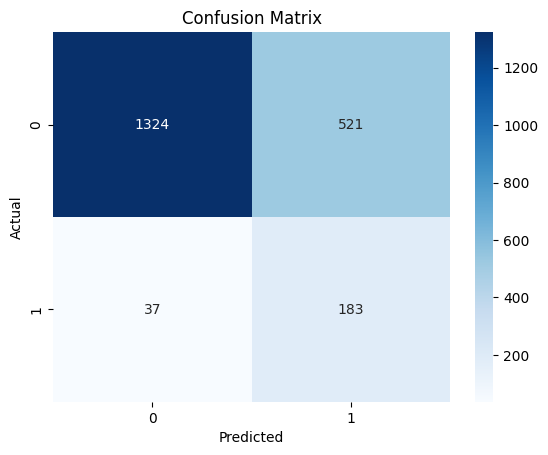

AUC: 0.8253091894555309
Log Loss: 0.49756102423867443


In [36]:
cm = confusion_matrix(y_test, y_pred_label)
auc = roc_auc_score(y_test, y_pred_prob)
loss = log_loss(y_test, y_pred_prob)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("AUC:", auc)
print("Log Loss:", loss)

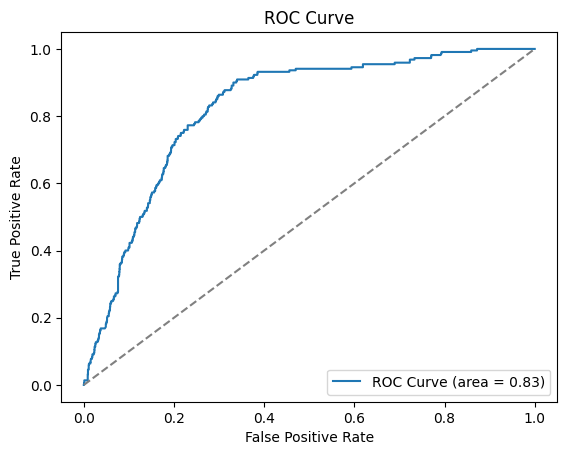

In [37]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], '--', color='gray')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()  

### Multi Modal ML experimenation using Optuna

In [38]:
!pip install optuna xgboost lightgbm 

  Using cached xgboost-3.2.0-py3-none-macosx_12_0_arm64.whl.metadata (2.1 kB)
  Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl.metadata (17 kB)
Using cached xgboost-3.2.0-py3-none-macosx_12_0_arm64.whl (2.3 MB)
Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [lightgbm]

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import optuna
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state= 42)

def objective(trial):

    model_type = trial.suggest_categorical(
        "model_type",
        ["logistic", "rf", "xgb", "lgbm"]
    )

    if model_type == "logistic":
        model = LogisticRegression(
            solver="saga",
            C=trial.suggest_float("C", 1e-4, 10, log=True),
            max_iter = 5000
        )

    if model_type == "rf":
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 1000),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            random_state=42
        )    

    if model_type == "xgb":
        model = xgb.XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 1000),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            learning_rate=trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )

    if model_type == "lgbm":
        model = lgb.LGBMClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 1000),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            learning_rate=trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            random_state=42
        )
        
        
    pipeline = Pipeline(steps=[
        ("clean", FunctionTransformer(clean_data)),
        ("feature_engineer", FunctionTransformer(feature_engineer_dates)),
        ("preprocess", preprocessor),
        ("model", model)
    ])

    score = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring="roc_auc"
    ).mean()

    return score


In [44]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=75)

print("Best Model:", study.best_params["model_type"])
print("Best Score:", study.best_value)
print("Best Params:", study.best_params)

[I 2026-02-16 12:28:21,915] A new study created in memory with name: no-name-4e837d85-7360-4330-a7ac-66f8676d37c7
[I 2026-02-16 12:28:29,105] Trial 0 finished with value: 0.8337035120552407 and parameters: {'model_type': 'rf', 'n_estimators': 766, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8337035120552407.
[I 2026-02-16 12:28:29,357] Trial 1 finished with value: 0.675329539309358 and parameters: {'model_type': 'logistic', 'C': 0.00021003837930744836}. Best is trial 0 with value: 0.8337035120552407.
[I 2026-02-16 12:28:29,605] Trial 2 finished with value: 0.6963096784670149 and parameters: {'model_type': 'logistic', 'C': 0.002492082703460355}. Best is trial 0 with value: 0.8337035120552407.
[I 2026-02-16 12:28:38,388] Trial 3 finished with value: 0.8339494341962157 and parameters: {'model_type': 'rf', 'n_estimators': 907, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8339494341962157.
[

[LightGBM] [Info] Number of positive: 537, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 4624, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116133 -> initscore=-2.029568
[LightGBM] [Info] Start training from score -2.029568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1480
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 537, number of negative: 4088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1484
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116108 -> initscore=-2.029813
[LightGBM] [Info] Start training from score -2.029813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-02-16 12:29:01,123] Trial 8 finished with value: 0.8251974616000048 and parameters: {'model_type': 'lgbm', 'n_estimators': 951, 'max_depth': 16, 'learning_rate': 0.019469614018599073, 'subsample': 0.9369379054868698, 'colsample_bytree': 0.7231237712723768}. Best is trial 5 with value: 0.8343352823678979.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2026-02-16 12:29:10,120] Trial 9 finished with value: 0.8359846622648105 and parameters: {'model_type': 'rf', 'n_estimators': 914, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 9 with value: 0.8359846622648105.


[LightGBM] [Info] Number of positive: 537, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 4624, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116133 -> initscore=-2.029568
[LightGBM] [Info] Start training from score -2.029568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1500
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1480
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1485
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116108 -> initscore=-2.029813
[LightGBM] [Info] Start training from score -2.029813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-02-16 12:29:15,245] Trial 10 finished with value: 0.8048602715935257 and parameters: {'model_type': 'lgbm', 'n_estimators': 632, 'max_depth': 5, 'learning_rate': 0.25182410290606294, 'subsample': 0.5160036284198519, 'colsample_bytree': 0.5047803523108874}. Best is trial 9 with value: 0.8359846622648105.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2026-02-16 12:29:16,595] Trial 11 finished with value: 0.8334504071072446 and parameters: {'model_type': 'rf', 'n_estimators': 113, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.8359846622648105.
[I 2026-02-16 12:29:19,187] Trial 12 finished with value: 0.8318593803582441 and parameters: {'model_type': 'rf', 'n_estimators': 295, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 9 with value: 0.8359846622648105.
[I 2026-02-16 12:29:23,284] Trial 13 finished with value: 0.8340154168876575 and parameters: {'model_type': 'rf', 'n_estimators': 450, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 9 with value: 0.8359846622648105.
/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [12:29:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are no

[LightGBM] [Info] Number of positive: 537, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1509
[LightGBM] [Info] Number of data points in the train set: 4624, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116133 -> initscore=-2.029568
[LightGBM] [Info] Start training from score -2.029568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1516
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1476
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1468
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 537, number of negative: 4088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1469
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116108 -> initscore=-2.029813
[LightGBM] [Info] Start training from score -2.029813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-02-16 12:29:58,433] Trial 19 finished with value: 0.7951193145924129 and parameters: {'model_type': 'lgbm', 'n_estimators': 572, 'max_depth': 14, 'learning_rate': 0.29445424239127127, 'subsample': 0.7473445300726229, 'colsample_bytree': 0.5292249142213843}. Best is trial 9 with value: 0.8359846622648105.
[I 2026-02-16 12:30:00,396] Trial 20 finished with value: 0.8097944051064466 and parameters: {'model_type': 'rf', 'n_estimators': 341, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.8359846622648105.
[I 2026-02-16 12:30:02,668] Trial 21 finished with value: 0.8312703554774583 and parameters: {'model_type': 'rf', 'n_estimators': 230, 'max_depth': 11, 'min_samples_split': 7, 'min_samples

[LightGBM] [Info] Number of positive: 537, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 4624, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116133 -> initscore=-2.029568
[LightGBM] [Info] Start training from score -2.029568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1464
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 537, number of negative: 4088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116108 -> initscore=-2.029813
[LightGBM] [Info] Start training from score -2.029813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-02-16 12:30:58,240] Trial 33 finished with value: 0.8306314778760472 and parameters: {'model_type': 'lgbm', 'n_estimators': 633, 'max_depth': 7, 'learning_rate': 0.006129854886136462, 'subsample': 0.6699735677255808, 'colsample_bytree': 0.8917367213638036}. Best is trial 9 with value: 0.8359846622648105.
[I 2026-02-16 12:30:59,639] Trial 34 finished with value: 0.81442873056842 and parameters: {'model_type': 'logistic', 'C': 0.58485911181473}. Best is trial 9 with value: 0.8359846622648105.
[I 2026-02-16 12:31:03,040] Trial 35 finished with value: 0.8346253493729068 and parameters: {'model_type': 'rf', 'n_estimators': 308, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 9 with value: 0.835984662264810

[LightGBM] [Info] Number of positive: 537, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1519
[LightGBM] [Info] Number of data points in the train set: 4624, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116133 -> initscore=-2.029568
[LightGBM] [Info] Start training from score -2.029568


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1509
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1461
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1461
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 537, number of negative: 4088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116108 -> initscore=-2.029813
[LightGBM] [Info] Start training from score -2.029813


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-02-16 12:31:42,400] Trial 45 finished with value: 0.8251762772029473 and parameters: {'model_type': 'lgbm', 'n_estimators': 272, 'max_depth': 13, 'learning_rate': 0.0003750030752963733, 'subsample': 0.84074936347855, 'colsample_bytree': 0.6521189125050249}. Best is trial 9 with value: 0.8359846622648105.
[I 2026-02-16 12:31:48,589] Trial 46 finished with value: 0.8361632659018831 and parameters: {'model_type': 'rf', 'n_estimators': 592, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 46 with value: 0.8361632659018831.
/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [12:31:48] WARNING: /Users/runner/work/xgboost/

[LightGBM] [Info] Number of positive: 537, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1522
[LightGBM] [Info] Number of data points in the train set: 4624, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116133 -> initscore=-2.029568
[LightGBM] [Info] Start training from score -2.029568


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1507
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1477
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 538, number of negative: 4087
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1463
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116324 -> initscore=-2.027708
[LightGBM] [Info] Start training from score -2.027708


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 537, number of negative: 4088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1487
[LightGBM] [Info] Number of data points in the train set: 4625, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116108 -> initscore=-2.029813
[LightGBM] [Info] Start training from score -2.029813


/Users/Patron/Github/Pharmaceutical-Supply-Chain-Optimisation/modeltest/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2026-02-16 12:33:12,176] Trial 65 finished with value: 0.8236833553370413 and parameters: {'model_type': 'lgbm', 'n_estimators': 160, 'max_depth': 16, 'learning_rate': 0.10088730090734946, 'subsample': 0.5294126485668205, 'colsample_bytree': 0.5979206367964425}. Best is trial 53 with value: 0.8370014229029549.
[I 2026-02-16 12:33:14,881] Trial 66 finished with value: 0.8346642549538492 and parameters: {'model_type': 'rf', 'n_estimators': 249, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 53 with value: 0.8370014229029549.
[I 2026-02-16 12:33:21,355] Trial 67 finished with value: 0.8339026285092077 and parameters: {'model_type': 'rf', 'n_estimators': 677, 'max_depth': 12, 'min_samples_split': 6, 'min_samp

Best Model: rf
Best Score: 0.8370014229029549
Best Params: {'model_type': 'rf', 'n_estimators': 429, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 4}


In [51]:
best_params = study.best_params.copy()

best_model_type = best_params.pop("model_type")

print("Best Model Type:", best_model_type)
print("Best Hyperparameters:", best_params)

Best Model Type: rf
Best Hyperparameters: {'n_estimators': 429, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 4}


In [53]:
if best_model_type == "logistic":
    model = LogisticRegression(
        solver="saga",
        max_iter=5000,
        **best_params
    )

elif best_model_type == "rf":
    model = RandomForestClassifier(
        random_state=42,
        **best_params
    )

elif best_model_type == "xgb":
    model = xgb.XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        **best_params
    )

elif best_model_type == "lgbm":
    model = lgb.LGBMClassifier(
        random_state=42,
        **best_params
    )

else:
    raise ValueError("Unknown model type")



final_pipeline = Pipeline([
    ("clean", FunctionTransformer(clean_data)),
    ("feature_engineer", FunctionTransformer(feature_engineer_dates)),
    ("preprocess", preprocessor),
    ("model", model)
])


final_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('clean', ...), ('feature_engineer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function cle...t 0x11755bd80>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments

In [54]:
#accuracy
y_pred = final_pipeline.predict(X_val)
print(classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, final_pipeline.predict_proba(X_val)[:, 1]))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      2184
           1       0.55      0.02      0.04       294

    accuracy                           0.88      2478
   macro avg       0.71      0.51      0.49      2478
weighted avg       0.84      0.88      0.83      2478

ROC AUC Score: 0.828260883107822
